# 2.5 웹 검색을 지원하는 Corrective RAG

- [Corrective Retrieval Augmented Generation](https://arxiv.org/pdf/2401.15884)논문을 구현합니다
- LangGraph 공식문서에 나온 흐름을 따라갑니다
    - 공식문서의 흐름은 간소화된 버전입니다.
    - 실제 논문과 유사한 구현은 3.3강을 참고해주세요
![corrective-rag](https://i.imgur.com/IzvmbWN.png)

In [1]:
from dotenv import load_dotenv

load_dotenv(dotenv_path="../.env")

True

In [2]:
# from langchain_openai import OpenAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma

# embedding_function = OpenAIEmbeddings(model="text-embedding-3-large")
embedding_function = HuggingFaceEmbeddings(model="BAAI/bge-m3")
collection_name = "chroma-income-tax-ollama_embedding"
vector_store = Chroma(
    collection_name=collection_name,
    embedding_function=embedding_function,
    persist_directory="./chroma"
)
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

c:\Users\a1ljm\Desktop\ANSWER_25\inflearn-langgraph-agent\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from typing import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list  # taviliy web_search를 위해 List[Document] -> list
    answer: str

workflow = StateGraph(AgentState)

In [4]:
from langchain_ollama import ChatOllama

llm_ollama = ChatOllama(model="llama3.1")

In [5]:
def retrieve(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 벡터 스토어에서 관련 문서를 검색합니다.
    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.
    Returns:
        AgentState: 검색된 문서가 추가된 state를 반환합니다.
    """
    print("retrieve")
    query = state["query"]
    docs = retriever.invoke(query)
    return {"context": docs}

- [rlm/rag-prompt](https://smith.langchain.com/hub/rlm/rag-prompt)
- HUMAN
    - You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
    - Question: {question} 
    - Context: {context} 
- Answer:

In [6]:
from langchain_classic import hub

# generate_llm = ChatOllama(model="llama3.1", max_completion_tokens=100)

def generate(state: AgentState) -> AgentState:
    """
    주어진 state를 기반으로 RAG 체인을 사용하여 응답을 생성합니다.
    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.
    Returns:
        AgentState: 생성된 응답을 포함하는 state를 반환합니다.
    """
    print("generate")
    query = state["query"]
    context = state["context"]
    generate_prompt = hub.pull("rlm/rag-prompt")
    generate_chain = generate_prompt | llm_ollama
    response = generate_chain.invoke({"question": query, "context": context})
    return {"answer": response}

- `retrieve` 노드에서 추출된 문서와 사용자의 질문이 관련이 있는지 판단합니다
    - 문서와 관련이 없다면 `rewrite` 노드로 이동해서 사용자의 질문을 변경합니다
        - `rewrite` 후 다시 `web_search` 노드로 이동해서 웹 검색을 합니다
    - 문서와 관련이 있다면 `generate` 노드로 이동해서 답변을 생성합니다

- [langchain-ai/rag-document-relevance](https://smith.langchain.com/hub/langchain-ai/rag-document-relevance)
- HUMAN
    - FACTS: {{documents}}
    - QUESTION: {{question}}
- Score:
    - A score of 1 means that the FACT contain ANY keywords or semantic meaning related to the QUESTION and are therefore relevant. This is the highest (best) score. 
    - A score of 0 means that the FACTS are completely unrelated to the QUESTION. This is the lowest possible score you can give.

In [7]:
from typing import Literal

def is_doc_relevant(state: AgentState) -> Literal["relevant", "irrelevant"]:
    """
    주어진 state를 기반으로 문서의 관련성을 판단합니다.
    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.
    Returns:
        Literal['relevant', 'irrelevant']: 문서가 관련성이 높으면 'relevant', 그렇지 않으면 'irrelevant'를 반환합니다.
    """
    print("is_doc_relevant")
    query = state["query"]
    context = state["context"]
    doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")
    doc_relevance_chain = doc_relevance_prompt | llm_ollama
    response = doc_relevance_chain.invoke({"question": query, "documents": context})
    if response["Score"] == 1:
        return "relevant"
    return "irrelevant"

In [8]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

def rewrite(state: AgentState) -> AgentState:
    """
    웹 검색을 쉽게 할 수 있도록 사용자의 질문을 바꿉니다.
    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.
    Returns:
        AgentState: 변경된 질문을 포함하는 state를 반환합니다.
    """
    print("rewrite")
    query = state["query"]
    rewrite_prompt = PromptTemplate.from_template(
        """ 웹 검색을 쉽게 할 수 있도록 사용자의 질문을 바꿔주세요.
            질문: {query} """
    )
    rewrite_chain = rewrite_prompt | llm_ollama | StrOutputParser()
    response = rewrite_chain.invoke({"query": query})
    return {"query": response}

- `web_search` 노드에서 웹 검색을 합니다
- `retrieve` 결과 대신 웹 검색 결과를 사용합니다
    - 웹 검색 결과는 [TavilySearchResults](https://tavily.com/) 툴을 사용합니다

In [18]:
from langchain_tavily import TavilySearch

def web_search(state: AgentState) -> AgentState:
    """
    주어진 state를 기반으로 웹 검색을 수행합니다.
    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.
    Returns:
        AgentState: 웹 검색 결과가 추가된 state를 반환합니다.
    """
    print("web_search")
    query = state["query"]
    tavily_search = TavilySearch(
        max_results=3,
        topic="general",  # "news", "finance" 등
        include_answer=True,
        include_raw_content=True,
        include_images=True,
        search_depth="advanced",  # "basic"
    )
    results = tavily_search.invoke(query)
    return {"context": results}

- `node`를 추가하고 `edge`로 연결합니다

In [12]:
from langgraph.graph import START, END

workflow.add_node("retrieve", retrieve)
workflow.add_node("generate", generate)
# workflow.add_node("rewrite", rewrite)
workflow.add_node("web_search", web_search)

workflow.add_edge(START, "retrieve")
workflow.add_conditional_edges("retrieve", is_doc_relevant, {
    "relevant": "generate",
    "irrelevant": "web_search",  # "rewrite" 불필요 -> 바로 "web_search"
})
# workflow.add_edge("rewrite", "web_search")
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

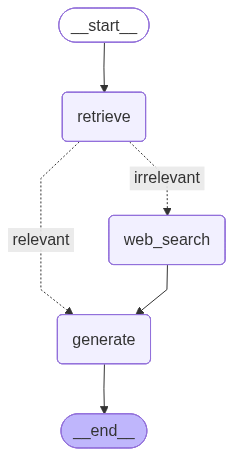

In [13]:
from IPython.display import display, Image

graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
question_1 = "연봉 5천만원 거주자의 소득세는 얼마인가요?"
response_1 = graph.invoke({"query": question_1})
response_1

retrieve
is_doc_relevant
generate


{'query': '연봉 5천만원 거주자의 소득세는 얼마인가요?',
 'context': [Document(id='af7d994c-dca7-4503-90fc-5ab84e74ae38', metadata={'source': './documents/income_tax_ocr.text'}, page_content='cS 과세기간의 종합소득금액\n=== 페이지 39 시작 ===\n[일반 텍스트]\n법제처                                                            39                                                       국가법령정보센터\n소득세법\n[전문개정 2009. 12. 31.]\n \n제59조(근로소득세액공제) ①근로소득이 있는 거주자에 대해서는 그 근로소득에 대한 종합소득산출세액에서 다음의\n금액을 공제한다. <개정 2014. 1. 1., 2015. 5. 13.>\n② 제1항에도 불구하고 공제세액이 다음 각 호의 구분에 따른 금액을 초과하는 경우에 그 초과하는 금액은 없는 것\n으로 한다.<신설 2014. 1. 1., 2015. 5. 13., 2022. 12. 31.>\n1. 총급여액이 3천 300만원 이하인 경우: 74만원\n2. 총급여액이 3천 300만원 초과 7천만원 이하인 경우: 74만원 - [(총급여액 - 3천 300만원) × 8/1000]. 다만, 위 금\n액이 66만원보다 적은 경우에는 66만원으로 한다.\n3. 총급여액이 7천만원 초과 1억2천만원 이하인 경우: 66만원 - [(총급여액 - 7천만원) × 1/2]. 다만, 위 금액이 50만\n원보다 적은 경우에는 50만원으로 한다.\n4. 총급여액이 1억2천만원을 초과하는 경우: 50만원 - [(총급여액 - 1억2천만원) × 1/2]. 다만, 위 금액이 20만원보다\n적은 경우에는 20만원으로 한다.\n③ 일용근로자의 근로소득에 대해서 제134조제3항에 따른 원천징수를 하는 경우에는 해당 근로소득에 대한 산출

In [15]:
print(response_1["answer"].content)

연봉이 5천만원인 경우, 소득세는 총급여액이 7천만원을 초과하는 경우에 적용되며, 공제금액은 66만원 - [(총급여액 - 7천만원) × 1/2]입니다. 하지만 이 금액이 50만원보다 적으면 50만원으로 제한됩니다.


In [16]:
question_2 = "AI Agent에 대해서 3줄로 요약해 주세요"
response_2 = graph.invoke({"query": question_2})
response_2

retrieve
is_doc_relevant
web_search
generate


{'query': 'AI Agent에 대해서 3줄로 요약해 주세요',
 'context': {'query': 'AI Agent에 대해서 3줄로 요약해 주세요',
  'follow_up_questions': None,
  'answer': 'An AI agent is an autonomous system that perceives, infers goals, plans actions, and executes tasks to achieve objectives. It can perform multi-step operations and integrate external tools. AI agents enhance efficiency in complex, goal-oriented tasks.',
  'images': ['https://i.ytimg.com/vi/FTJ1uhHoM9Y/maxresdefault.jpg',
   'https://lookaside.fbsbx.com/lookaside/crawler/media/?media_id=1241504387976821',
   'https://lookaside.fbsbx.com/lookaside/crawler/media/?media_id=1253831753410751',
   'https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https://blog.kakaocdn.net/dna/bdOfmT/btsNNBSzMo1/AAAAAAAAAAAAAAAAAAAAAMzcEQmwXS8uzgW_OR0afuf3pAG0EdydtPpYc_IXxnTE/img.png?credential=yqXZFxpELC7KVnFOS48ylbz2pIh7yKj8&expires=1756652399&allow_ip=&allow_referer=&signature=WkxASZlwAVNa76p1iigrc1Q%2FZ8A%3D',
   'https://i.ytimg.com/vi/oUPNozp8M8g/maxres2.jpg?sq

In [17]:
print(response_2["answer"].content)

AI 에이전트란 무엇이며 AI 에이전트의 장점은 무엇일까요?
